<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

DataFrames on a Cluster
=======================

<img src="https://pandas.pydata.org/static/img/pandas.svg"
     align="left"
     width="30%"
     alt="Pandas logo">



This notebook needs the [gcsfs library](https://gcsfs.readthedocs.io).

    pip install gcsfs

## Read single dataframe from the cloud with Pandas

In [1]:
from gcsfs import GCSFileSystem

gcs = GCSFileSystem(token='anon')

gcs.ls('anaconda-public-data/nyc-taxi/csv/')

['anaconda-public-data/nyc-taxi/csv/',
 'anaconda-public-data/nyc-taxi/csv/2014',
 'anaconda-public-data/nyc-taxi/csv/2015',
 'anaconda-public-data/nyc-taxi/csv/2016']

In [1]:

nyc_datatype = {'VendorID': 'string',
                'passenger_count': 'int32',
                'trip_distance': 'float32',
                'pickup_longitude': 'float32',
                'pickup_latitude': 'float32',
                'RateCodeID': 'string',
                'store_and_fwd_flag': 'string',
                'dropoff_longitude': 'float32',
                'dropoff_latitude': 'float32',
                'payment_type': 'string',
                'fare_amount': 'float32',
                'extra': 'float32',
                'mta_tax': 'float32',
                'tip_amount': 'float32',
                'tolls_amount': 'float32',
                'improvement_surcharge': 'float32',
                'total_amount':'float32' }

## Parallelize Pandas with Dask.dataframe


In [2]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress, wait


In [3]:

client = Client()
client

2022-12-25 20:26:01,000 - distributed.diskutils - INFO - Found stale lock file and directory '/rapids/notebooks/host/docker-pyspark/dask-docker/workspace/dask-worker-space/worker-hzwnm4eu', purging
2022-12-25 20:26:01,000 - distributed.diskutils - INFO - Found stale lock file and directory '/rapids/notebooks/host/docker-pyspark/dask-docker/workspace/dask-worker-space/worker-r3o8cwa0', purging
2022-12-25 20:26:01,001 - distributed.diskutils - INFO - Found stale lock file and directory '/rapids/notebooks/host/docker-pyspark/dask-docker/workspace/dask-worker-space/worker-xne_w8d3', purging
2022-12-25 20:26:01,001 - distributed.diskutils - INFO - Found stale lock file and directory '/rapids/notebooks/host/docker-pyspark/dask-docker/workspace/dask-worker-space/worker-7xcfrfcj', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.36 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34515,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.36 GiB
Comm: tcp://127.0.0.1:39671,Total threads: 2
Dashboard: http://127.0.0.1:40605/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:38563,


In [15]:
df1 = dd.read_parquet("data/yellow_tripdata_2014.parquet")
df2 = dd.read_parquet("data/yellow_tripdata_2015.parquet")

df1 = df1.astype(nyc_datatype)
df2 = df2.astype(nyc_datatype)
df = dd.concat( [df1, df2], axis=0 )

In [4]:
df = dd.read_parquet("data/nyc_taxi/yellow_tripdata_2020-*.parquet")



In [5]:
df = df.persist()
progress(df)

VBox()

In [6]:
%time wait(df)
%time print(df.passenger_count.sum().compute())


CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 971 µs
34995422.0
CPU times: user 32.1 ms, sys: 2.94 ms, total: 35 ms
Wall time: 86.4 ms



Dask DataFrames
---------------

*  Coordinate many Pandas DataFrames across a cluster
*  Faithfully implement a subset of the Pandas API
*  Use Pandas under the hood (for speed and maturity)

In [7]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=12,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                      object
dtype: object

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [10]:
%time len(df)

CPU times: user 20 ms, sys: 2.06 ms, total: 22 ms
Wall time: 29 ms


24649092

In [11]:
%time df.passenger_count.sum().compute()

CPU times: user 27.9 ms, sys: 4.05 ms, total: 32 ms
Wall time: 67.1 ms


34995422.0

In [12]:
# Compute average trip distance grouped by passenger count
df.groupby(df.passenger_count).trip_distance.mean().compute()

passenger_count
0.0    2.570004
1.0    2.717219
2.0    2.891465
3.0    2.808439
4.0    2.868655
5.0    2.752731
6.0    2.790439
7.0    3.688681
8.0    3.811207
9.0    3.903922
Name: trip_distance, dtype: float64

### Tip Fraction, grouped by day-of-week and hour-of-day

In [24]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount

In [25]:
# Group df.tpep_pickup_datetime by dayofweek and hour
dayofweek = df2.groupby(df2.tpep_pickup_datetime.dt.dayofweek).tip_fraction.mean() 
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()

dayofweek, hour = dask.persist(dayofweek, hour)
progress(dayofweek, hour)

VBox()

### Plot results

This requires matplotlib to be installed

In [26]:
%matplotlib inline

<AxesSubplot: title={'center': 'Tip Fraction by Hour'}, xlabel='tpep_pickup_datetime'>

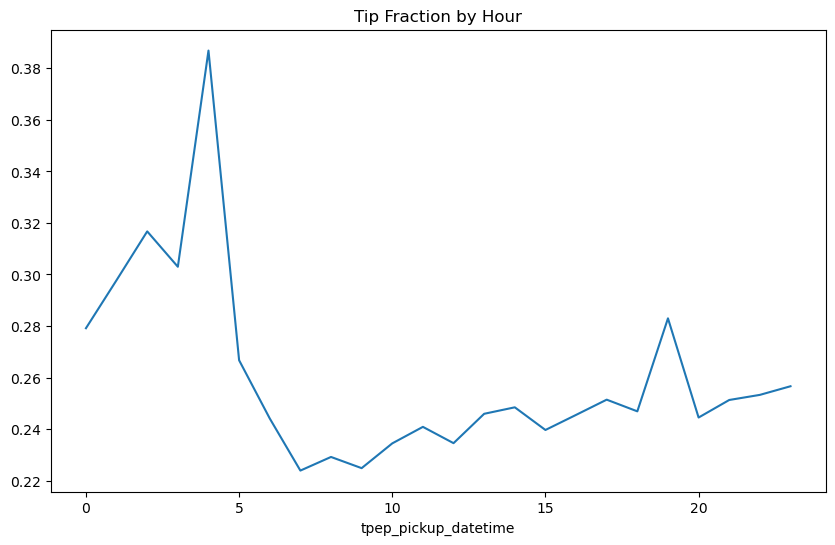

In [27]:
hour.compute().plot(figsize=(10, 6), title='Tip Fraction by Hour')